# Movie Data Analysis: Ratings, Recommendations, and Networks

*This notebook is a Python translation of the R Markdown analysis.*

---

## Part 1: Predicting Ratings from Tags and Genre

### 1.1: Setup and Data Loading

First, we import all the necessary Python libraries and load the three main data files using pandas.

In [55]:
# --- Essential Libraries ---
import pandas as pd
import numpy as np

# --- Machine Learning ---
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import MultiLabelBinarizer

# --- Association Rule Mining ---
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# --- Network Analysis ---
import networkx as nx
from networkx.algorithms.community import girvan_newman, modularity

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Notebook Settings ---
sns.set_style("whitegrid")
%matplotlib inline

# --- Load Data ---
# Note: Ensure these CSV files are in the same directory as your notebook.
movies_df = pd.read_csv("movies.csv")
scores_df = pd.read_csv("scores.csv")
tags_df = pd.read_csv("attributes.csv")

print("Data loaded successfully.")
print(f"Movies: {movies_df.shape}")
print(f"Scores: {scores_df.shape}")
print(f"Tags: {tags_df.shape}")

Data loaded successfully.
Movies: (9742, 3)
Scores: (100836, 4)
Tags: (3683, 4)


### 1.2: Assemble Predictor (X) and Response (Y) Matrices

We will now precisely replicate the R script's data preparation steps to create our `X` and `Y` DataFrames.

#### Create the Response Vector Y (Average Ratings)

This replicates the `tapply` command to calculate the average rating for each movie.

In [56]:
Y = scores_df.groupby('movieId')['rating'].mean().to_frame(name='average_rating')
Y.index = Y.index.astype(str) # Match R's character rownames

print("Y DataFrame (average ratings) created. Shape:", Y.shape)
Y.head()

Y DataFrame (average ratings) created. Shape: (9724, 1)


,average_rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429


#### Create the Predictor Matrix for Genres (`X_genre`)

Pandas' `str.get_dummies` is a direct equivalent to R's method of creating dummy variables from the genre strings.

In [57]:
# Create 0/1 dummy variables from the pipe-separated 'genres' column
X_genre = movies_df['genres'].str.get_dummies(sep='|')
X_genre.index = movies_df['movieId'].astype(str)
X_genre = X_genre.sort_index(axis=1) # R sorts columns alphabetically

print("X_genre DataFrame created. Shape:", X_genre.shape)
X_genre.head()

X_genre DataFrame created. Shape: (9742, 20)


,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Create the Predictor Matrix for Attributes (`A`)

To ensure identical results, we first create the **full** matrix of all tags, and only then do we filter it to keep tags that appear in more than 10 movies.

In [58]:
# 1. Replicate R's `split` and `lapply(..., unique)`
tags_grouped = tags_df.groupby('movieId')['tag'].apply(lambda x: list(set(x)))
tags_grouped.index = tags_grouped.index.astype(str)

# 2. Create the full incidence matrix (`A_full`) before filtering
mlb = MultiLabelBinarizer()
A_full = pd.DataFrame(mlb.fit_transform(tags_grouped), columns=mlb.classes_, index=tags_grouped.index)
A_full = A_full.sort_index(axis=1)

# 3. Filter the matrix to keep only tags that appear in more than 10 movies
tag_sums = A_full.sum(axis=0)
popular_tags = tag_sums[tag_sums > 10].index
A = A_full[popular_tags]

print(f"Filtered attribute matrix 'A' created. Shape: {A.shape}")

Filtered attribute matrix 'A' created. Shape: (1572, 43)


#### Combine and Align X and Y

We use `DataFrame.join(how='inner')` to perfectly replicate R's filtering and matching logic in a clean, efficient way.

In [59]:
# 1. Combine the attribute matrix (A) and genre matrix (X_genre)
X = A.join(X_genre, how='inner')

# 2. Align the combined X matrix with the Y vector (average ratings)
final_data = X.join(Y, how='inner')

# 3. Separate into the final, fully aligned X and Y objects
Y_final = final_data[['average_rating']]
X_final = final_data.drop('average_rating', axis=1)

print("Final Alignment Complete.")
print(f"Final X shape: {X_final.shape}")
print(f"Final Y shape: {Y_final.shape}")
print(f"We have {len(X_final)} movies with complete data, matching the R output.")

Final Alignment Complete.
Final X shape: (1554, 63)
Final Y shape: (1554, 1)
We have 1554 movies with complete data, matching the R output.


---

## 1.3: LASSO Analysis

We use `LassoCV` from scikit-learn to perform LASSO regression with built-in cross-validation to find the optimal penalty term (alpha). Note the `gamlr` package in R is not directly appliable. 

Best alpha (penalty) found via cross-validation: 0.0009


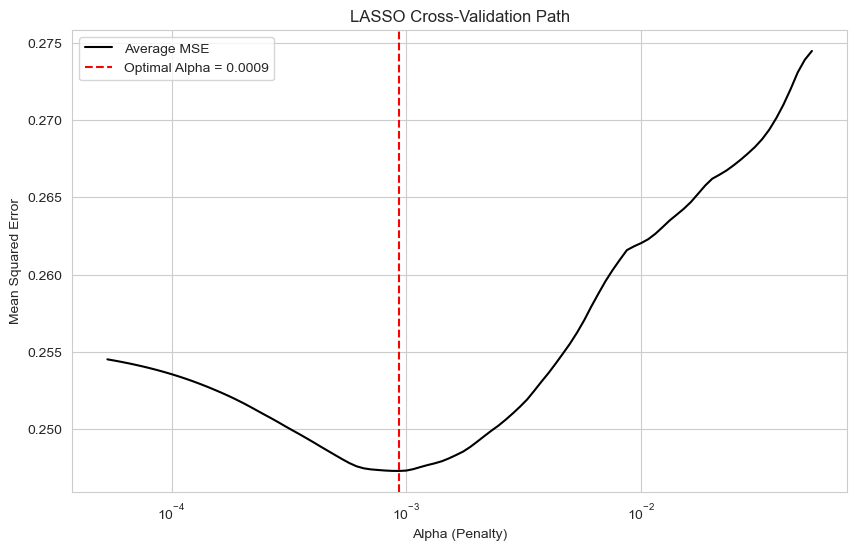

In [60]:
# Fit the LassoCV model to find the best alpha
lasso_cv = LassoCV(cv=10, random_state=1, max_iter=10000)
lasso_cv.fit(X_final, Y_final.values.ravel())

print(f"Best alpha (penalty) found via cross-validation: {lasso_cv.alpha_:.4f}")

# Plot the cross-validation MSE path (similar to `plot(cv.gamlr)`)
plt.figure(figsize=(10, 6))
plt.semilogx(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=-1), 'k', label='Average MSE')
plt.axvline(lasso_cv.alpha_, linestyle='--', color='r', label=f'Optimal Alpha = {lasso_cv.alpha_:.4f}')
plt.legend()
plt.xlabel('Alpha (Penalty)')
plt.ylabel('Mean Squared Error')
plt.title('LASSO Cross-Validation Path')
plt.show()

Now, we extract the coefficients from the optimal model. These are the tags and genres most predictive of a movie's rating.

## Midterm (1.1): LASSO Spaghetti Plot

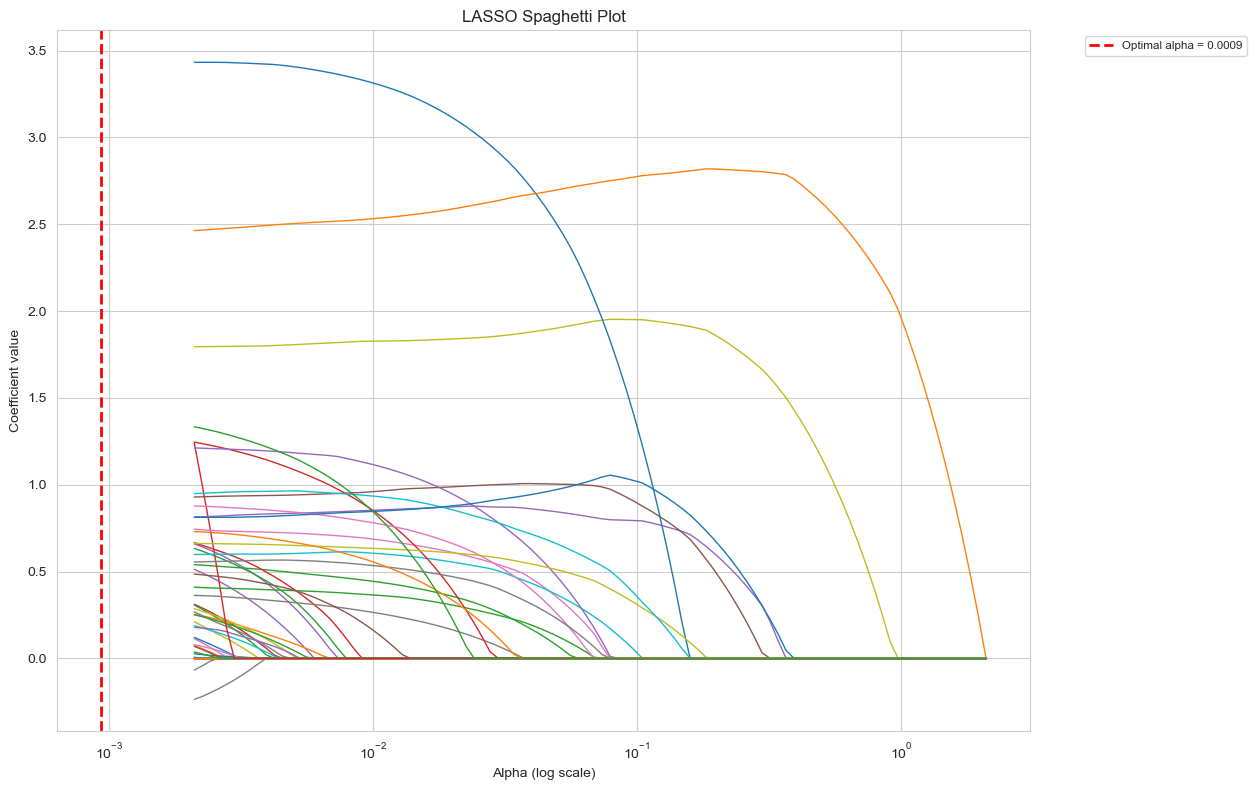

The LASSO spaghetti plot above shows how the coefficients change as the penalty of alpha (lambda) changes. The optimal lambda is 0.0009 plotted as the vertical red dotted line. Each colored line represents a coefficient of X (e.g., attributes or genres).

The LASSO analysis is pushing weaker coefficients to 0 so that stronger coefficients can stand out from the noise. The optimal penalty as shown above from the cross validation chart will zero out multiple coefficients to leave only the strong ones for analysis. Below we will print some of the top coefficients to look at.


In [61]:
from sklearn.linear_model import Lasso, LassoCV, lasso_path
import matplotlib.pyplot as plt

# Fit final LASSO model using the best alpha
lasso_final = Lasso(alpha=lasso_cv.alpha_, max_iter=10000)
lasso_final.fit(X_final, Y_final.values.ravel())

# Extract coefficients
coef = pd.Series(lasso_final.coef_, index=X_final.columns)

# Compute coefficient paths manually for the spaghetti plot
alphas_lasso, coefs_lasso, _ = lasso_path(X_final, Y_final.values.ravel(), max_iter=10000)

plt.figure(figsize=(16, 8))

# Plot coefficient paths
for i in range(coefs_lasso.shape[0]):
    plt.plot(alphas_lasso, coefs_lasso[i, :], lw=1)

# Find coefficients at the chosen alpha
alpha_idx = (np.abs(alphas_lasso - lasso_cv.alpha_)).argmin()
coefs_at_alpha = coefs_lasso[:, alpha_idx]

plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Coefficient value')
plt.title('LASSO Spaghetti Plot')
plt.axvline(lasso_cv.alpha_, color='r', linestyle='--', linewidth=2, label=f'Optimal alpha = {lasso_cv.alpha_:.4f}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()

print("The LASSO spaghetti plot above shows how the coefficients change as the penalty of alpha (lambda) changes. The optimal lambda is 0.0009 plotted as the vertical red dotted line. Each colored line represents a coefficient of X (e.g., attributes or genres).")
print("\nThe LASSO analysis is pushing weaker coefficients to 0 so that stronger coefficients can stand out from the noise. The optimal penalty as shown above from the cross validation chart will zero out multiple coefficients to leave only the strong ones for analysis. Below we will print some of the top coefficients to look at.")

In [62]:
coefficients = pd.Series(lasso_cv.coef_, index=X_final.columns)
selected_features = coefficients[coefficients != 0]

print(f"The LASSO model selected {len(selected_features)} features.")
print("\n--- Top 10 Positive Predictors ---")
print(selected_features.sort_values(ascending=False).head(10))
print("\n--- Top 10 Negative Predictors ---")
print(selected_features.sort_values(ascending=True).head(10))

print("\nThis shows that there are 45 active coefficients and the strongest positive predictors are 'black comedy', 'animation', and 'documentary' while the strongest negative predictors are 'horror', 'superhero', and 'children'")
print("\nThe story this analysis tells is effectively what the movie population likes and doesn't like from our dataset. For example, it would make sense Horror films typically don't get great ratings because many movie watchers including myself don't like the category at all. Similarly, negative predictors like 'politics' or 'adultery' are pretty obvious scenarios where the movies may miss the mark with a not as pleasing topic to the general public and therefore get worse ratings. Let's also look at the positive predictors. This is where we see some of the most liked types of movie attributes like black comedy which is a specific type of funny content people lvoe as well as emotional and drama which both are one of the largest movie categories for women right next to war, sci-fi, and western, which are probably also the top categories for men to watch.")
print("\nAlso, one thing to consider here is the way these movies make people feel. The positive predictors typically handle bold and resonating topics that are well liked for their higher engagement of people from all background. The negative predictors to contrast are more constrained to movie watchers that like that specific genre for instance boxing has a great following of people that love boxing yet doesn't appeal to everybody due to violence.")

The LASSO model selected 45 features.

--- Top 10 Positive Predictors ---
black comedy        0.284351
Animation           0.232920
Documentary         0.225559
Western             0.207313
Drama               0.153728
Film-Noir           0.146380
In Netflix queue    0.145928
War                 0.143881
emotional           0.140550
sci-fi              0.127144
dtype: float64

--- Top 10 Negative Predictors ---
Horror        -0.311372
superhero     -0.287865
Children      -0.188100
high school   -0.164544
Comedy        -0.096567
Action        -0.083660
boxing        -0.050342
adultery      -0.048064
Fantasy       -0.039405
politics      -0.038966
dtype: float64

This shows that there are 45 active coefficients and the strongest positive predictors are 'black comedy', 'animation', and 'documentary' while the strongest negative predictors are 'horror', 'superhero', and 'children'

The story this analysis tells is effectively what the movie population likes and doesn't like from our datas

## Midterm (1.2): Out of Sample Prediction Error

In [67]:
# Best out-of-sample prediction error (minimum CV MSE)
best_mse = np.min(lasso_cv.mse_path_.mean(axis=-1))
best_rmse = np.sqrt(best_mse)

# Optimal penalty (lambda)
best_lambda = lasso_cv.alpha_

# Number of active (nonzero) coefficients at optimal lambda
num_active = np.sum(lasso_final.coef_ != 0)

print(f"Best out-of-sample MSE: {best_mse:.4f}")
print(f"Optimal penalty (lambda): {best_lambda:.4f}")
print(f"Number of active features: {num_active}")

print("\nWhat we see by the above calculations is that the penalty for lambda that gives us the best prediction will be 0.0009 which is the same as what we saw as the vertical red dotted line on the previous charts. This lambda leaves 45 active attributes/genres to contribute to prediction.")
print("\nThe smallest out of sample prediction error is shown above as MSE=0.25 which represents the mean squared error. This is the minimum average squared distance between the true ratings and the model's predicted ratings. To make it more meaningful we can take the square root which is about 0.50. This means the model will predict the movie ratings within about 1 point (0.50 up and 0.50 down) from the actual ratings. With this MSE value we want to observe the smallest number possible and this is sufficient in my opinion.")


Best out-of-sample MSE: 0.2473
Optimal penalty (lambda): 0.0009
Number of active features: 45

What we see by the above calculations is that the penalty for lambda that gives us the best prediction will be 0.0009 which is the same as what we saw as the vertical red dotted line on the previous charts. This lambda leaves 45 active attributes/genres to contribute to prediction.

The smallest out of sample prediction error is shown above as MSE=0.25 which represents the mean squared error. This is the minimum average squared distance between the true ratings and the model's predicted ratings. To make it more meaningful we can take the square root which is about 0.50. This means the model will predict the movie ratings within about 1 point (0.50 up and 0.50 down) from the actual ratings. With this MSE value we want to observe the smallest number possible and this is sufficient in my opinion.


## Midterm (1.3): LASSO "Slice" Interpretation

In [65]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso

# Choose fold 0
kf = KFold(n_splits=10, shuffle=True, random_state=1)
train_idx, val_idx = list(kf.split(X_final))[0]  # first fold

X_train, Y_train = X_final.iloc[train_idx], Y_final.iloc[train_idx]
X_val, Y_val = X_final.iloc[val_idx], Y_final.iloc[val_idx]

# Fit Lasso on this fold with the optimal alpha
lasso_fold0 = Lasso(alpha=lasso_cv.alpha_, max_iter=10000)
lasso_fold0.fit(X_train, Y_train.values.ravel())

# Extract coefficients for this fold
coef_fold0 = pd.Series(lasso_fold0.coef_, index=X_final.columns)
selected_features_fold0 = coef_fold0[coef_fold0 != 0]

# Print fold-specific results
print(f"The LASSO model selected {len(selected_features_fold0)} features in fold 0 vs. the above total model")

print("\n--- Top 10 Positive Predictors ---")
print(selected_features_fold0.sort_values(ascending=False).head(10))

print("\n--- Top 10 Negative Predictors ---")
print(selected_features_fold0.sort_values(ascending=True).head(10))


print("\nBy looking at a single slice out of the 10 slices we can see how the coefficients change due to sample differences (or hopefully overlap) especially to test if most of the coefficients still appear in the top 10.")
print("\nFor instance we see black comedy, documentary, and animation, again for positive predictors and horror, superhero and highschool for negative predictors. That's great! We also see some addiitonal nuances of the smaller sliace which adds imdb toip 250 or dark into the positive predictors when they weren't there previously. This just means in that specific slice those attributes become predictors of higher ratings, but then when incorporated into the whole model they slip out of the top 10")
print("\nAnother good thing to see is that the selected features remains 45 which means the model is relatively stable at the slice and whole level. ")


The LASSO model selected 45 features in fold 0 vs. the above total model

--- Top 10 Positive Predictors ---
black comedy        0.246657
Documentary         0.243046
Animation           0.232779
Western             0.187012
imdb top 250        0.163872
War                 0.163278
suspense            0.155765
Drama               0.153305
In Netflix queue    0.144923
dark                0.111138
dtype: float64

--- Top 10 Negative Predictors ---
Horror        -0.293969
superhero     -0.287367
high school   -0.166327
Children      -0.161650
Comedy        -0.097161
Action        -0.083342
boxing        -0.060032
adultery      -0.054177
Fantasy       -0.052638
politics      -0.046104
dtype: float64

By looking at a single slice out of the 10 slices we can see how the coefficients change due to sample differences (or hopefully overlap) especially to test if most of the coefficients still appear in the top 10.

For instance we see black comedy, documentary, and animation, again for positive

## Midterm (1.4): Further LASSO interpretation (e.g., "Horror")

Looking back at the full model. Horror as an attribute had the coefficient = -0.3114 what this means is that if two movies had the exact same attributes but one had Horror and one did not, the horror movie would have a lower rating by 0.31 on the ratings scale. 
The awesome part about this analysis is that we can use the coefficients to say: all else equal, if a movie is horror and the other isnt than we can predict the horror movie to have lower 0.31 rating score.

Another way to consider this is looking at black comedy on the positive side. If two movies had identical attributes except one had black comedy and the other didn't then the black comedy movie we would preedict would have 0.28 higher points in the reviews simply for that attribute.


---

## Part 2: Building a Recommender System

We will use **association rule mining** to find relationships between movies, using the `mlxtend` library.

### 2.1: Prepare Transaction Data

We transform the ratings data into a "transaction" format, where each transaction is a list of movies a user rated highly (4 stars or more).

In [8]:
# Filter for ratings of 4 or higher
subset = scores_df[scores_df['rating'] >= 4].copy()

# Merge to get movie titles
subset = pd.merge(subset, movies_df[['movieId', 'title']], on='movieId')

# Create a list of lists (the transaction format)
movielists = subset.groupby('userId')['title'].apply(list).tolist()

# Encode the data into a one-hot DataFrame
te = TransactionEncoder()
transactions_df = pd.DataFrame(te.fit_transform(movielists), columns=te.columns_)

print("Transaction data prepared.")
transactions_df.head()

Transaction data prepared.


,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),...,Zombieland (2009),Zookeeper (2011),Zoolander (2001),Zootopia (2016),Zulu (1964),[REC] (2007),[REC]² (2009),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### 2.2: Mine for Association Rules

We use the **Apriori algorithm** to find rules based on support, confidence, and lift.

#### Find High-Confidence, High-Support Rules

Rules with at least **10% support** and **95% confidence**.

In [9]:
frequent_itemsets1 = apriori(transactions_df, min_support=0.1, use_colnames=True)
rules1 = association_rules(frequent_itemsets1, metric="confidence", min_threshold=0.95)

print("Found", len(rules1), "high-confidence, high-support rules.")
rules1.head()

Found 41 high-confidence, high-support rules.


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,"(Godfather: Part II, The (1974))","(Godfather, The (1972))",0.175698,0.259442,0.167488,0.953271,3.674317,1.0,0.121904,15.847947,0.882978,0.625767,0.936900,0.799420
1,"(Fight Club (1999), Godfather: Part II, The (1...","(Godfather, The (1972))",0.100164,0.259442,0.100164,1.000000,3.854430,1.0,0.074177,inf,0.822993,0.386076,1.000000,0.693038
2,"(Lord of the Rings: The Two Towers, The (2002)...","(Lord of the Rings: The Return of the King, Th...",0.119869,0.229885,0.114943,0.958904,4.171233,1.0,0.087387,18.739464,0.863806,0.489510,0.946637,0.729452
3,"(Forrest Gump (1994), Lord of the Rings: The T...","(Lord of the Rings: The Return of the King, Th...",0.110016,0.229885,0.106732,0.970149,4.220149,1.0,0.081441,25.798851,0.857366,0.457746,0.961239,0.717217
4,"(Goodfellas (1990), Godfather: Part II, The (1...","(Godfather, The (1972))",0.101806,0.259442,0.100164,0.983871,3.792262,1.0,0.073751,45.914614,0.819762,0.383648,0.978220,0.684973


#### Find High-Lift Rules

Rules with at least **5% support**, **50% confidence**, and a **lift greater than 10**.

In [10]:
frequent_itemsets2 = apriori(transactions_df, min_support=0.05, use_colnames=True)

# Run below if your computing resource is sufficient.
# frequent_itemsets2 = apriori(transactions_df, min_support=0.01, use_colnames=True)

rules2 = association_rules(frequent_itemsets2, metric="confidence", min_threshold=0.5)

subrules = rules2[rules2['lift'] > 10]

print("Found", len(subrules), "high-lift rules.")
# Sort by lift to see the strongest associations
subrules.sort_values(by='lift', ascending=False).head(10)

Found 262 high-lift rules.


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
210075,(Star Wars: Episode V - The Empire Strikes Bac...,"(Kill Bill: Vol. 2 (2004), Star Wars: Episode ...",0.067323,0.059113,0.052545,0.780488,13.203252,1.0,0.048565,4.286262,0.990977,0.711111,0.766696,0.834688
210066,"(Kill Bill: Vol. 2 (2004), Star Wars: Episode ...",(Star Wars: Episode V - The Empire Strikes Bac...,0.059113,0.067323,0.052545,0.888889,13.203252,1.0,0.048565,8.394089,0.982330,0.711111,0.880869,0.834688
210059,"(Kill Bill: Vol. 2 (2004), Star Wars: Episode ...","(Kill Bill: Vol. 1 (2003), Star Wars: Episode ...",0.060755,0.067323,0.052545,0.864865,12.846407,1.0,0.048455,6.901806,0.981807,0.695652,0.855110,0.822676
210080,"(Kill Bill: Vol. 2 (2004), Star Wars: Episode ...",(Star Wars: Episode V - The Empire Strikes Bac...,0.067323,0.060755,0.052545,0.780488,12.846407,1.0,0.048455,4.278781,0.988721,0.695652,0.766289,0.822676
210081,"(Kill Bill: Vol. 1 (2003), Star Wars: Episode ...","(Kill Bill: Vol. 2 (2004), Star Wars: Episode ...",0.067323,0.060755,0.052545,0.780488,12.846407,1.0,0.048455,4.278781,0.988721,0.695652,0.766289,0.822676
210061,(Star Wars: Episode V - The Empire Strikes Bac...,"(Kill Bill: Vol. 2 (2004), Star Wars: Episode ...",0.060755,0.067323,0.052545,0.864865,12.846407,1.0,0.048455,6.901806,0.981807,0.695652,0.855110,0.822676
210087,(Star Wars: Episode V - The Empire Strikes Bac...,"(Matrix, The (1999), Kill Bill: Vol. 2 (2004),...",0.075534,0.054187,0.052545,0.695652,12.837945,1.0,0.048452,3.107671,0.997447,0.680851,0.678216,0.832675
210050,"(Matrix, The (1999), Kill Bill: Vol. 2 (2004),...",(Star Wars: Episode V - The Empire Strikes Bac...,0.054187,0.075534,0.052545,0.969697,12.837945,1.0,0.048452,30.507389,0.974935,0.680851,0.967221,0.832675
210076,"(Kill Bill: Vol. 2 (2004), Star Wars: Episode ...","(Kill Bill: Vol. 1 (2003), Star Wars: Episode ...",0.065681,0.062397,0.052545,0.800000,12.821053,1.0,0.048447,4.688013,0.986819,0.695652,0.786690,0.821053
210071,"(Kill Bill: Vol. 2 (2004), Matrix, The (1999),...",(Star Wars: Episode V - The Empire Strikes Bac...,0.062397,0.065681,0.052545,0.842105,12.821053,1.0,0.048447,5.917351,0.983363,0.695652,0.831005,0.821053


---

## Part 3: Network Analysis of Movie Relationships

We visualize the high-lift association rules as a network using `networkx`.

### 3.1: Build and Visualize the Movie Network

Movies are nodes, and a rule represents an edge between them.

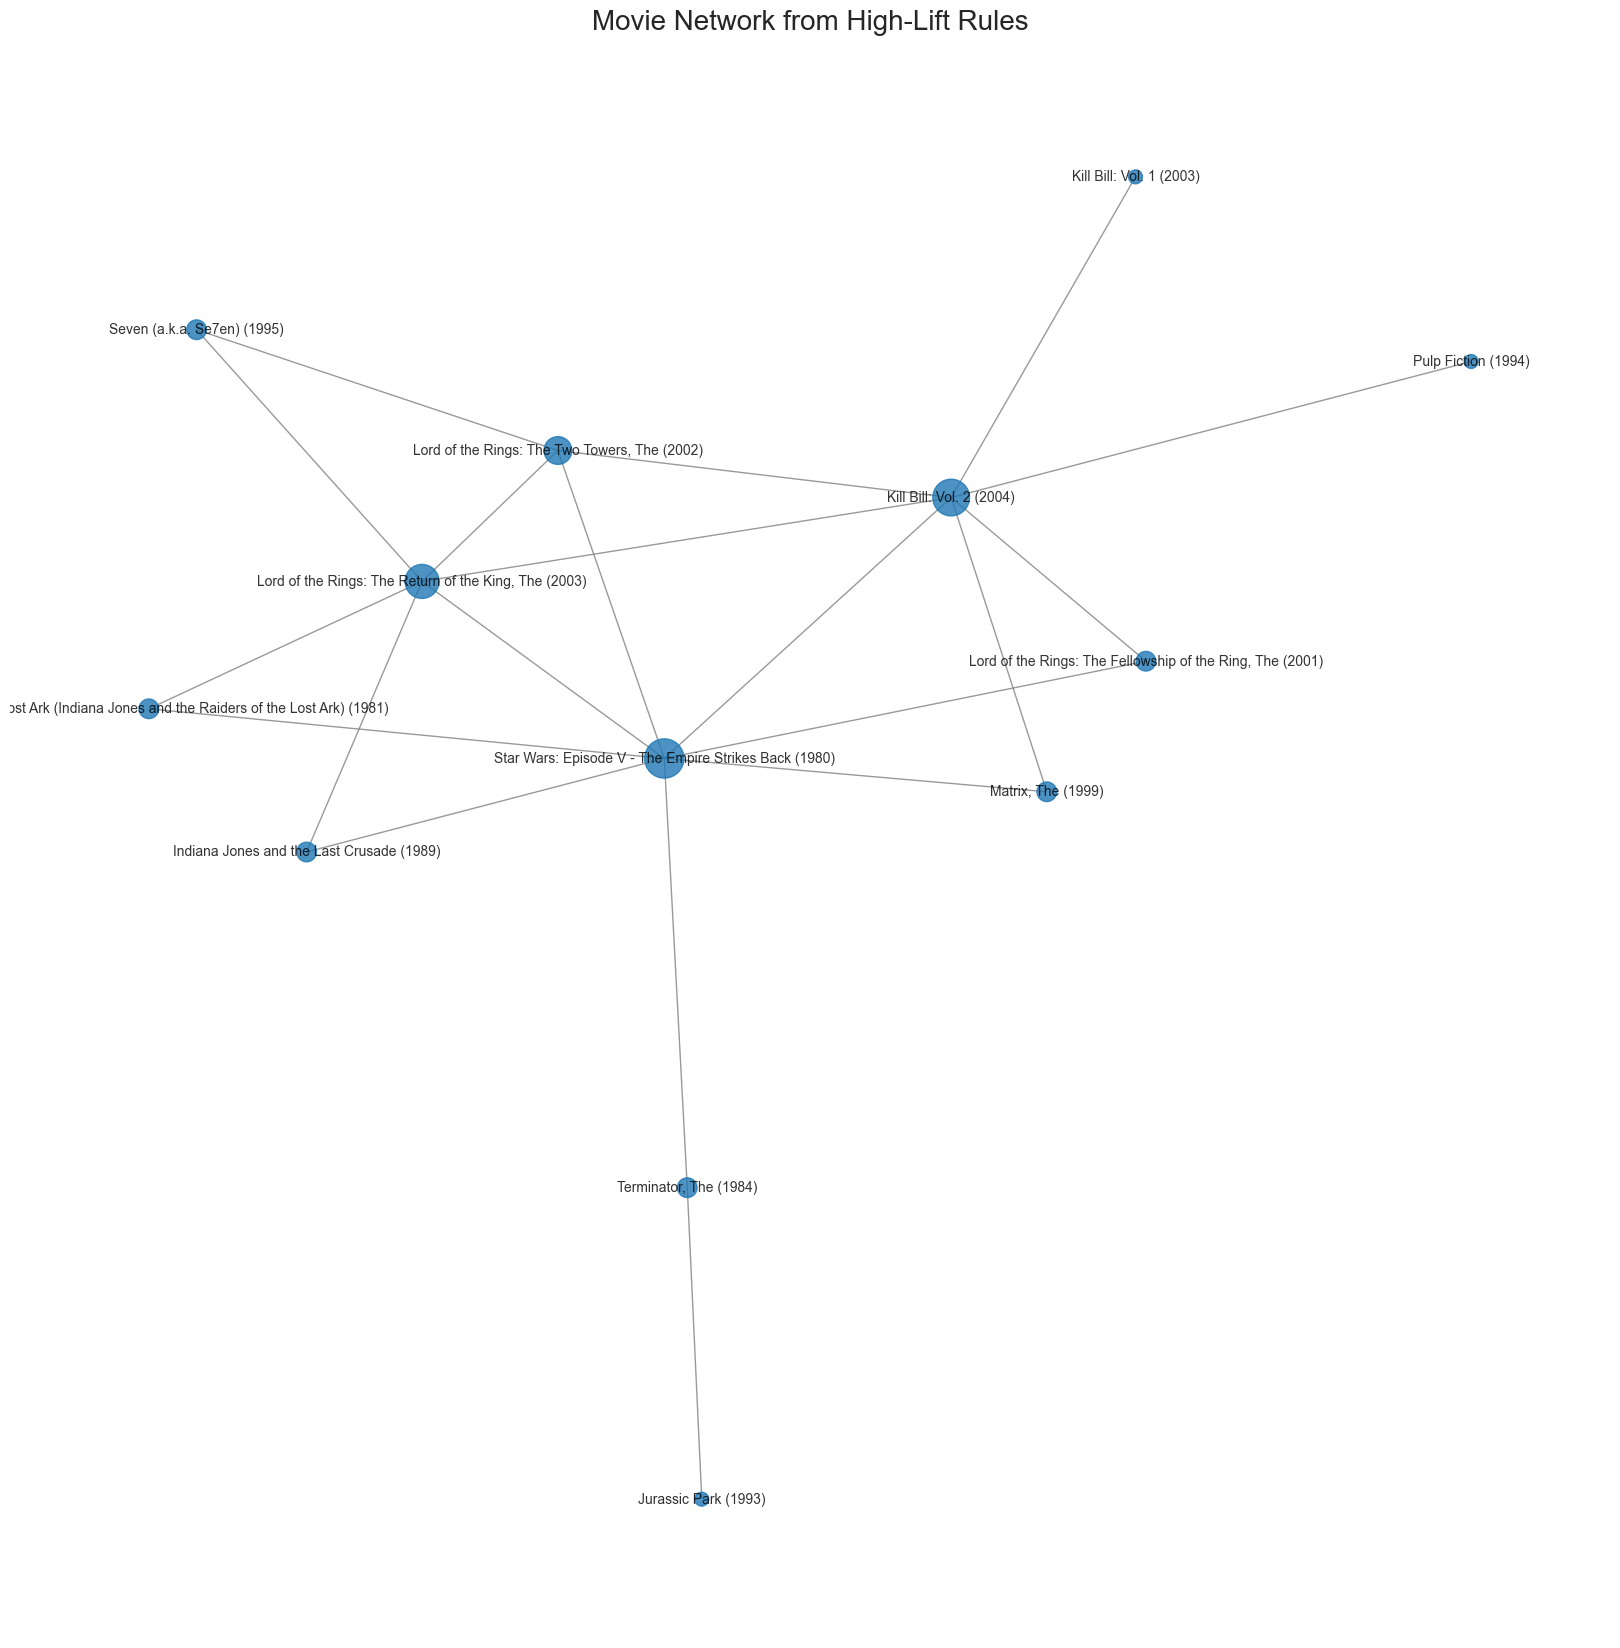

In [11]:
# The 'antecedents' and 'consequents' columns are frozensets, so we extract the movie titles
pairs = subrules[['antecedents', 'consequents']].copy()
pairs['antecedents'] = pairs['antecedents'].apply(lambda x: list(x)[0])
pairs['consequents'] = pairs['consequents'].apply(lambda x: list(x)[0])

# Create the graph from the edge list
movienet = nx.from_pandas_edgelist(pairs, 'antecedents', 'consequents')

# Plot the network, sizing nodes by their degree (number of connections)
plt.figure(figsize=(16, 16))
pos = nx.spring_layout(movienet, k=0.2)
degrees = dict(nx.degree(movienet))
node_sizes = [v * 100 for v in degrees.values()]

nx.draw(movienet, pos, with_labels=True, node_size=node_sizes, 
        font_size=10, font_color="black", edge_color="gray", alpha=0.8)
plt.title("Movie Network from High-Lift Rules", size=20)
plt.show()

### 3.2: Identify Key Movies with Centrality Measures

In [12]:
# --- Degree Centrality (Popularity) ---
degree_centrality = nx.degree_centrality(movienet)
sorted_degree = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)
print("--- Top 10 Movies by Degree Centrality ---")
for movie, centrality in sorted_degree[:10]:
    print(f"- {movie}")

# --- Betweenness Centrality (Bridge-like role) ---
betweenness_centrality = nx.betweenness_centrality(movienet)
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)
print("\n--- Top 10 Movies by Betweenness Centrality ---")
for movie, centrality in sorted_betweenness[:10]:
    print(f"- {movie}")

--- Top 10 Movies by Degree Centrality ---
- Star Wars: Episode V - The Empire Strikes Back (1980)
- Kill Bill: Vol. 2 (2004)
- Lord of the Rings: The Return of the King, The (2003)
- Lord of the Rings: The Two Towers, The (2002)
- Lord of the Rings: The Fellowship of the Ring, The (2001)
- Seven (a.k.a. Se7en) (1995)
- Indiana Jones and the Last Crusade (1989)
- Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
- Matrix, The (1999)
- Terminator, The (1984)

--- Top 10 Movies by Betweenness Centrality ---
- Star Wars: Episode V - The Empire Strikes Back (1980)
- Kill Bill: Vol. 2 (2004)
- Terminator, The (1984)
- Lord of the Rings: The Return of the King, The (2003)
- Lord of the Rings: The Two Towers, The (2002)
- Kill Bill: Vol. 1 (2003)
- Lord of the Rings: The Fellowship of the Ring, The (2001)
- Pulp Fiction (1994)
- Seven (a.k.a. Se7en) (1995)
- Indiana Jones and the Last Crusade (1989)


---

## Part 4: Discovering Movie Communities

### 4.1: Find Communities with Edge Betweenness

We use the Girvan-Newman algorithm to find communities and select the partition with the highest modularity score.

In [13]:
# Find communities using the Girvan-Newman algorithm
communities_generator = girvan_newman(movienet)

# Find the partition with the best modularity
best_modularity = -1
best_partition = None
for partition in communities_generator:
    current_modularity = modularity(movienet, partition)
    if current_modularity > best_modularity:
        best_modularity = current_modularity
        best_partition = partition

print(f"Found {len(best_partition)} communities with a best modularity of {best_modularity:.3f}")

Found 2 communities with a best modularity of 0.089


### 4.2: Visualize and Explore Communities

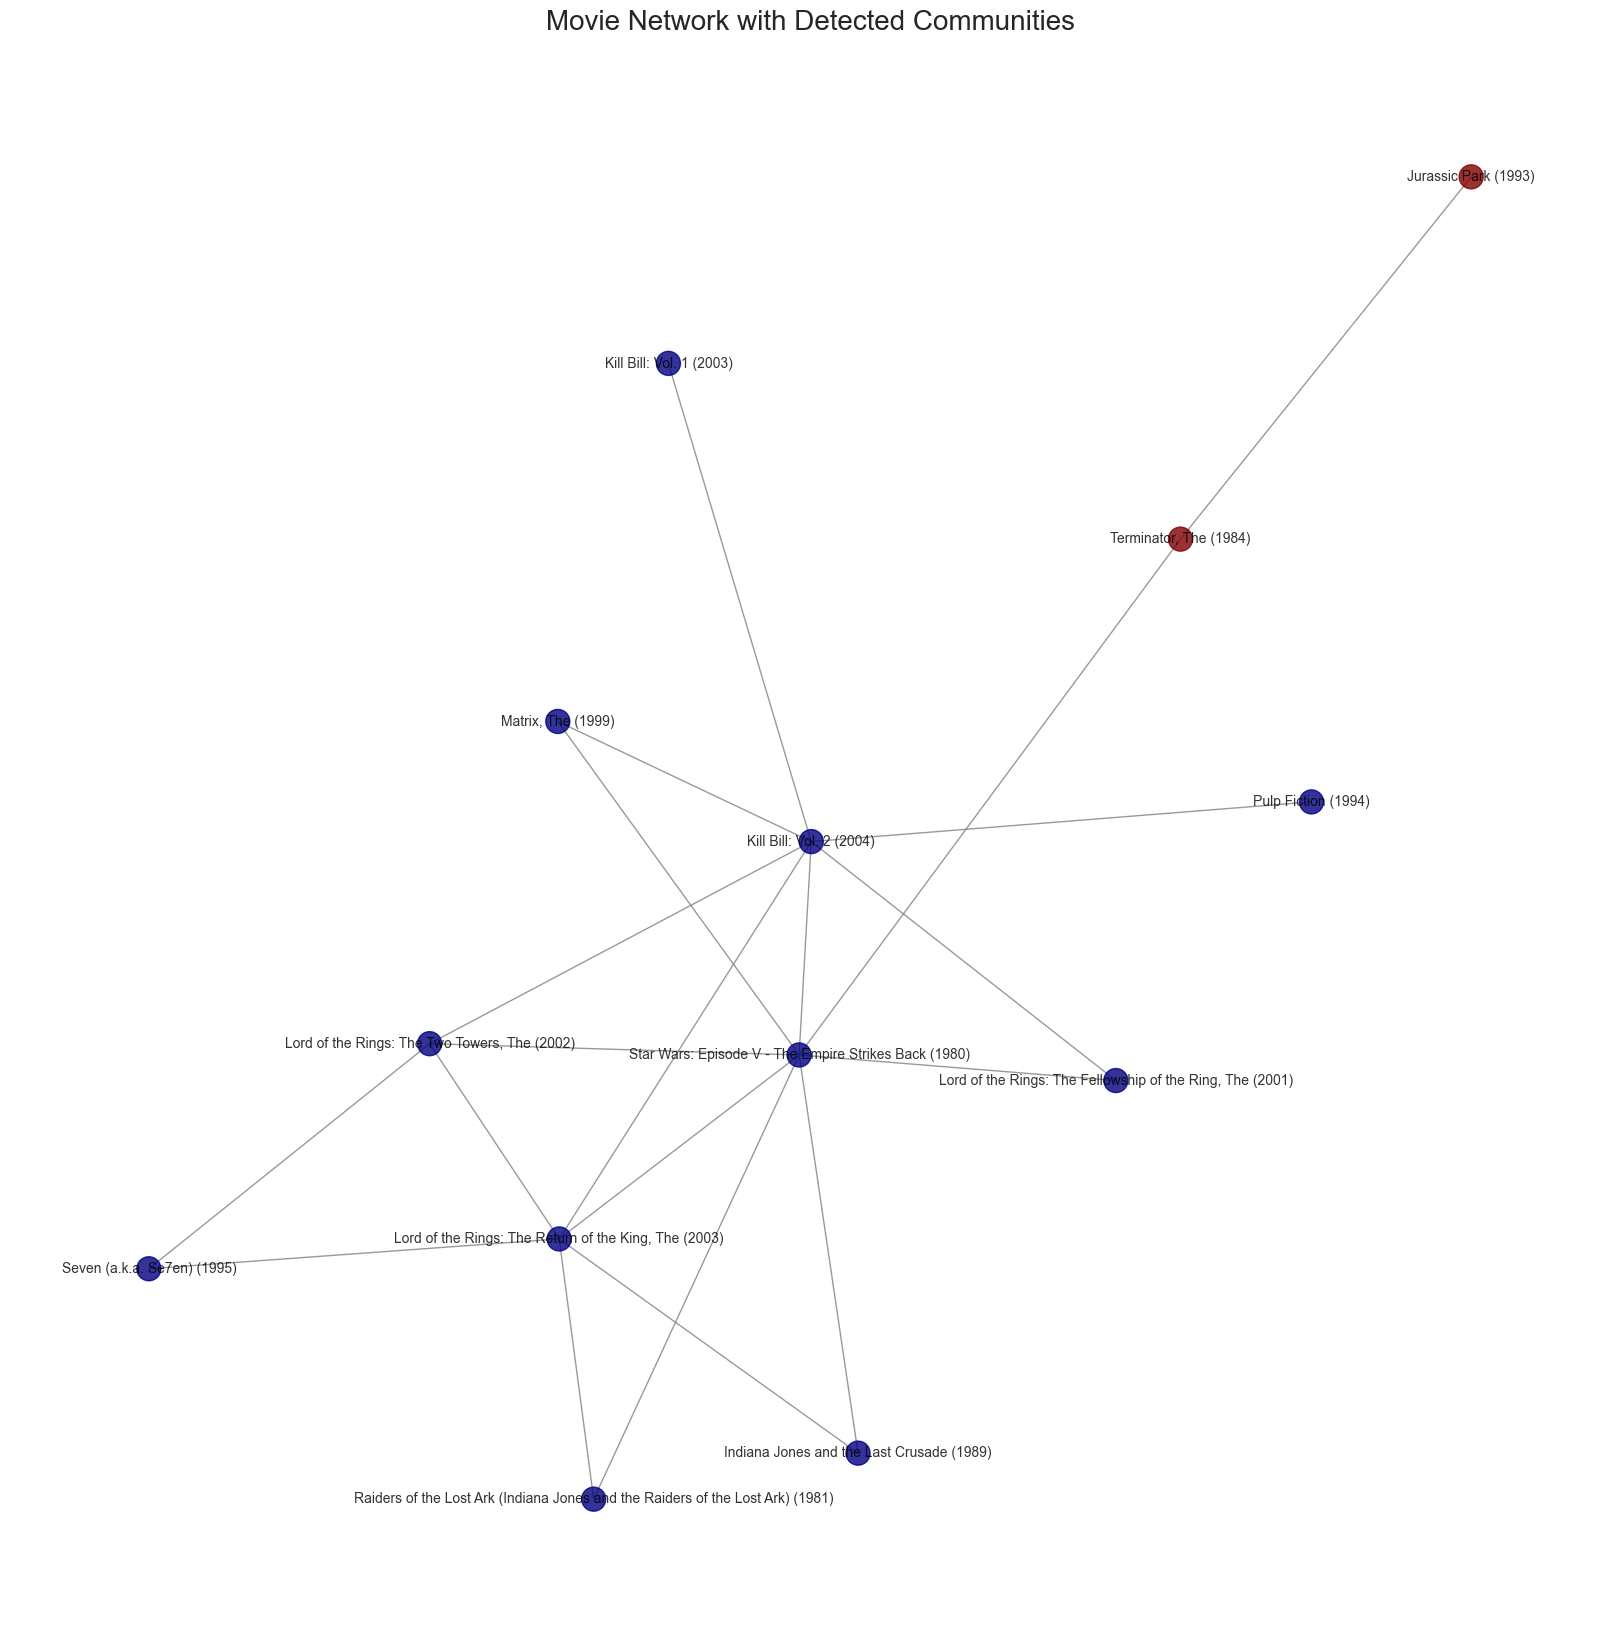

In [14]:
# Assign a community number to each node for coloring
community_map = {node: i for i, comm in enumerate(best_partition) for node in comm}
colors = [community_map.get(node, 0) for node in movienet.nodes()]

# Plot the network with communities colored
plt.figure(figsize=(16, 16))
pos = nx.spring_layout(movienet, k=0.2)
nx.draw(movienet, pos, node_color=colors, with_labels=True, cmap=plt.cm.jet,
        font_size=10, font_color="black", edge_color="gray", alpha=0.8)
plt.title("Movie Network with Detected Communities", size=20)
plt.show()

Let's inspect the movies within the first detected community.

In [15]:
community_0_nodes = sorted(list(best_partition[0]))
print("--- Movies in Community 0 ---")
print(community_0_nodes)

--- Movies in Community 0 ---
['Indiana Jones and the Last Crusade (1989)', 'Kill Bill: Vol. 1 (2003)', 'Kill Bill: Vol. 2 (2004)', 'Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Lord of the Rings: The Return of the King, The (2003)', 'Lord of the Rings: The Two Towers, The (2002)', 'Matrix, The (1999)', 'Pulp Fiction (1994)', 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', 'Seven (a.k.a. Se7en) (1995)', 'Star Wars: Episode V - The Empire Strikes Back (1980)']


---

## Part 5: Neighborhood and Ego Networks

Finally, we can explore the immediate neighborhood of a specific movie of interest (an "ego" node).

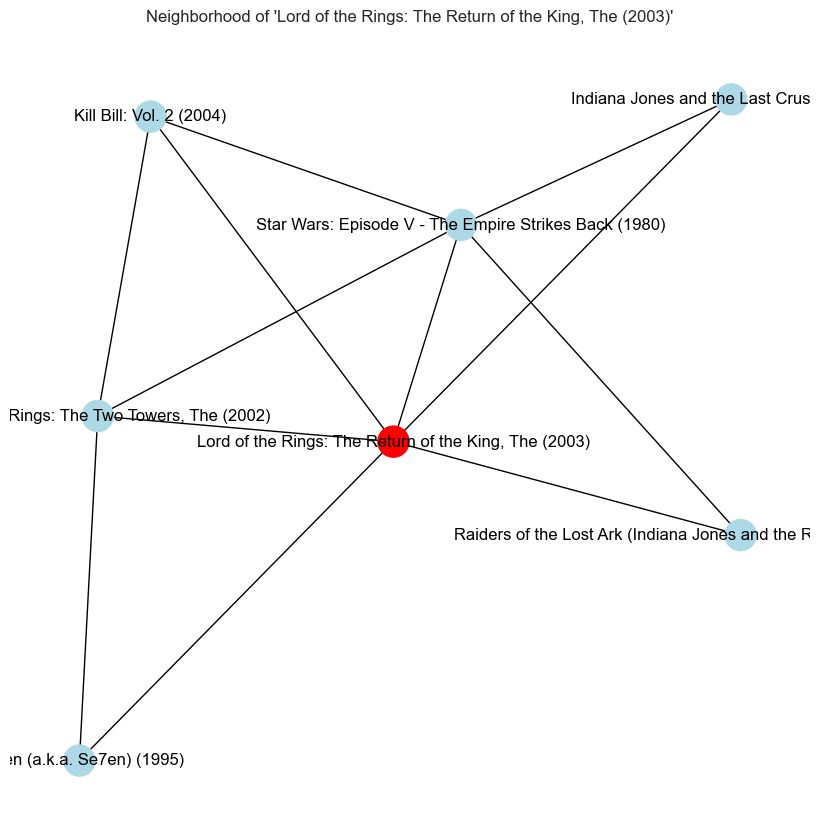

'Star Wars: Episode VI - Return of the Jedi (1983)' not in the network.


In [16]:
def plot_ego_network(graph, node_name):
    """Helper function to plot the ego network of a given node."""
    if node_name not in graph:
        print(f"'{node_name}' not in the network.")
        return
    
    # Create the ego network graph
    ego_net = nx.ego_graph(graph, node_name, radius=1)
    
    # Plotting
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(ego_net)
    
    # Color the central node differently
    node_colors = ['red' if node == node_name else 'lightblue' for node in ego_net.nodes()]
    
    nx.draw(ego_net, pos, with_labels=True, node_color=node_colors, node_size=500)
    plt.title(f"Neighborhood of '{node_name}'")
    plt.show()

# Plot the neighborhood network for 'Lord of the Rings'
plot_ego_network(movienet, 'Lord of the Rings: The Return of the King, The (2003)')

# Plot the neighborhood network for 'Star Wars: Episode VI'
plot_ego_network(movienet, 'Star Wars: Episode VI - Return of the Jedi (1983)')